In [1]:
import torch
import time
import snntorch as snn

lif = snn.Leaky(beta=0.9)
lif = lif.to('cuda')

num_steps = 20000

x = torch.rand(num_steps)
mem = torch.zeros(1)
spk = torch.zeros(1)

start_time = time.time()
for step in range(num_steps):
  spk, mem = lif(x[step], mem=None)

end_time = time.time()

print(f"{end_time-start_time}")

4.0837883949279785


In [3]:
lif = snn.LinearLeaky(beta=0.9)
lif = lif.to('cuda')

# lif = torch.compile(lif, mode="reduce-overhead", fullgraph=True, dynamic=False)

timesteps = 100000
batch = 1
channels = 1
print("timesteps: ", timesteps)
print("batch: ", batch)
print("channels: ", channels)
print()

input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to('cuda')
start_time = time.time()
lif.forward(input_)
end_time = time.time()

print(f"{end_time-start_time}")

timesteps:  100000
batch:  1
channels:  1

0.2286980152130127


Benchmark Results:

Timesteps  |  Leaky (s)  |  Linear Leaky (s)  |  Ratio (T2/T1)
-------------------------------------------------------
       10 |     0.0026 |     0.0005 |       0.18
       27 |     0.0048 |     0.0003 |       0.07
       77 |     0.0137 |     0.0004 |       0.03
      215 |     0.0390 |     0.0003 |       0.01
      599 |     0.1089 |     0.0003 |       0.00
     1668 |     0.3233 |     0.0003 |       0.00
     4641 |     0.8702 |     0.0004 |       0.00
    12915 |     2.5018 |     0.0003 |       0.00
    35938 |     6.8338 |     0.0004 |       0.00
   100000 |    18.7980 |     0.0003 |       0.00


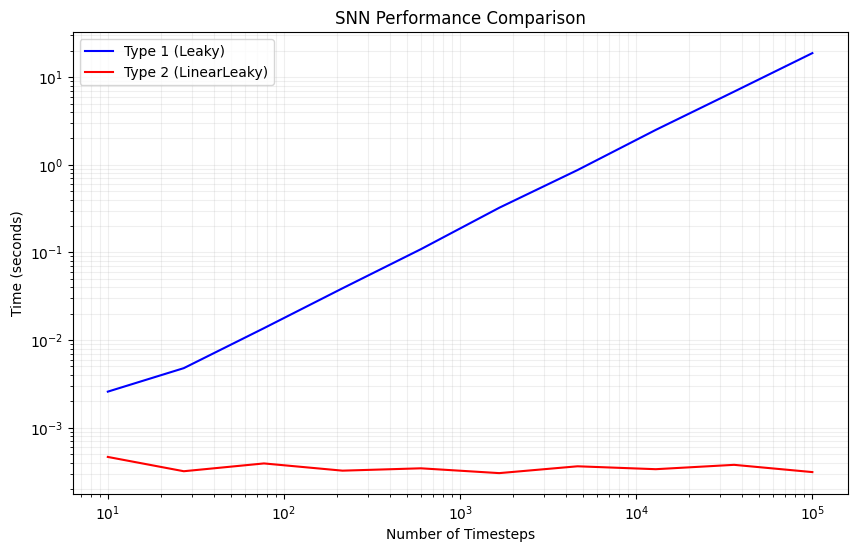

In [4]:
import torch
import time
import snntorch as snn
import numpy as np
import matplotlib.pyplot as plt

device = "cuda"

def bench_type1(num_steps):
    lif = snn.Leaky(beta=0.9).to(device)
    x = torch.rand(num_steps).to(device)
    mem = torch.zeros(1).to(device)
    spk = torch.zeros(1).to(device)
    
    start_time = time.time()
    for step in range(num_steps):
        spk, mem = lif(x[step], mem=None)
    end_time = time.time()
    
    return end_time - start_time

def bench_type2(timesteps):
    lif = snn.LinearLeaky(beta=0.9).to(device)
    batch = 1
    channels = 1
    input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to(device)
    
    start_time = time.time()
    lif.forward(input_)
    end_time = time.time()
    
    return end_time - start_time

# Define timesteps on log scale
timesteps = np.logspace(1, 5, num=10, dtype=int)

# Run benchmarks
times1 = []
times2 = []
for steps in timesteps:
    # Run each benchmark multiple times and take average for more stable results
    n_runs = 3
    time1 = np.mean([bench_type1(steps) for _ in range(n_runs)])
    time2 = np.mean([bench_type2(steps) for _ in range(n_runs)])
    times1.append(time1)
    times2.append(time2)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(timesteps, times1, 'b-', label='Type 1 (Leaky)')
plt.plot(timesteps, times2, 'r-', label='Type 2 (LinearLeaky)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Number of Timesteps')
plt.ylabel('Time (seconds)')
plt.title('SNN Performance Comparison')
plt.legend()

# Print the results
print("Benchmark Results:")
print("\nTimesteps  |  Leaky (s)  |  Linear Leaky (s)  |  Ratio (T2/T1)")
print("-" * 55)
for i, steps in enumerate(timesteps):
    ratio = times2[i] / times1[i]
    print(f"{steps:9d} | {times1[i]:10.4f} | {times2[i]:10.4f} | {ratio:10.2f}")

plt.show()